# Minimum Information Dependence modeling


Joint model for a mixed-domain data
proposed by Sei and Yano, Minimum information dependence modeling

$p(x; \theta, \nu)=\exp(\theta^{\top}h(x)-\sum_{j=1}^{d}a_{j}(x_j;\theta,\nu)-\psi(\theta,\nu))\prod_{j=1}^{d}r_{j}(x_{j};\nu)$

such that $a_{j}(x_j;\theta,\nu)$ and $\psi(\theta,\nu)$ are determined by

--mariginal condition $\int p(x;\theta,\nu)dx_{-j}=r_{j}(x_{j};\nu)$

--identifiability condition $\int \sum_{j=1}^{d} a_{j}(x_{j};\theta,\nu) p(x;\theta,\nu)dx=0$

In [1]:
#Import libraries

import numpy as np
import gc
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LogisticRegression
from scipy import linalg
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from google.colab import drive
drive.mount("/content/gdrive")
import glob
import os
import random
import matplotlib.gridspec as gridspec

Mounted at /content/gdrive


##Definition of functions we use
*  min_info_mcmc: MCMC sampler for the model

*  min_info_Besag: Pseudo likelihood estimation
*  min_info_Besag_bootstrap: empirical bootstrap for Pseudo likelihood estimation
*  min_info_Besag_score/Hessian/asymptoticCovariance: option of calculating the asymptotic covariance of Pseudo likelihood estimation

*  min_info_CLE: Conditional maximum likelihood estimation

In [2]:
## MCMC sampler for the minimum information dependence model with canonical statistics h and canonical parameter theta

def min_info_mcmc(X,h,loop,theta,printop=False):

###############################################################################
  #INPUT
  ## X: initial sample list [[multivariate sample 1],[multivariate sample 2],...]
  ## h   : canonical statistics function (from X (d-dim list) to R^K K-dim array)
  ## loop: number of mcmc steps
  ## theta: canonical parameter (np.array)
  ## printop: print option (if True then print the acceptance rate every 1000 steps)

  #OUTPUT
  ## list of Markov chains (list of Xs)
  ## output[0]  yields the input
  ## output[-1] yields the final output
###############################################################################

  if len(X) ==0:
    print("NULL list")
  else:
    n = len(X)
    d = len(X[0])
    output_list = [X]
    acceptancenum = 0
    for Li in range(loop):
      i  = random.sample(range(d),1)[0]
      s,t = random.sample(range(n),2)[0:2]
      X_iswap_s = output_list[Li][s].copy()
      X_iswap_t = output_list[Li][t].copy()

      X_iswap_s[i] = output_list[Li][t][i]
      X_iswap_t[i] = output_list[Li][s][i]

      h_diff = h(output_list[Li][s])+h(output_list[Li][t])-h(X_iswap_s)-h(X_iswap_t)
      log_rho_tilde  = np.min([np.log(1),-theta.dot(h_diff)])
      u  = np.random.uniform(low=0,high=1,size=1)
      if np.log(u) < log_rho_tilde:
        X_new = output_list[Li].copy()
        X_new[s] = X_iswap_s
        X_new[t] = X_iswap_t
        output_list.append(X_new)
        del X_new

        acceptancenum = acceptancenum + 1
      else:
        output_list.append(output_list[Li])
      del X_iswap_s
      del X_iswap_t
      if (Li % 10000 == 0):
        gc.collect()
      if (Li % 1000 == 0) and (printop == True):
        print("Step/Total : "+str(Li)+"/"+str(loop)+" Acceptance rate : "+str(np.round(acceptancenum/(Li+1),2)))
    return output_list

In [3]:
## Besag pseudo-likelihood estimation 

def min_info_Besag(X,h,max_iter,tol,sparseop=False,sparsepen=1.):

###############################################################################
  #INPUT
  ## X        : initial sample list [[multivariate sample 1],[multivariate sample 2],...]
  ## h        : canonical statistics (from X (d-dim list) to R^K)
  ## max_iter : number of iteration
  ## tol      : tolerance value for the optimizer
  ## sparseop : if True, add l1 penalty
  ## sparsepen: penalty strength valid only if sparseop is True. 

  #OUTPUT
  ## estimate (K-dim array)
###############################################################################

  if len(X) ==0:
    print("NULL list")
  else:
    n = len(X)
    d = len(X[0])
    Us = []
    Ys = []
    for i in range(d):
          for t in range(n):
            for s in range(t):

              X_iswap_s = X[s][:]
              X_iswap_t = X[t][:]
              X_iswap_s[i] = X[t][i]
              X_iswap_t[i] = X[s][i]
              Us.append(h(X[s])+h(X[t])-h(X_iswap_s)-h(X_iswap_t))
              if (t==(n-1))&(s == (n-2)):
                Ys.append(0)
              else:
                Ys.append(1)
    if sparseop==False:
      model = LogisticRegression(solver='liblinear',random_state=0,C=1e10,fit_intercept=False,tol=tol,max_iter=max_iter).fit(np.array(Us), Ys)
    else:
      model = LogisticRegression(solver='saga',random_state=0,C=sparsepen,penalty="l1",fit_intercept=False,tol=tol,max_iter=max_iter).fit(np.array(Us), Ys)
    return model.coef_[0]

In [4]:
## Bootstrap for Besag pseudo-likelihood estimation

def min_info_Besag_bootstrap(X,h,tol,max_iter,B,sparseop=False,sparsepen=1.):

###############################################################################
  #INPUT
  ## X       : initial sample list [[multivariate sample 1],[multivariate sample 2],...]
  ## h       : canonical statistics (from X (d-dim list) to R^K)
  ## max_iter: size of iteration
  ## tol     : tolerance value for the optimizer
  ## B       : size of bootstrap samples 
  ## sparseop : if True, add l1 penalty
  ## sparsepen: penalty strength valid only if sparseop is True. 

  #OUTPUT
  ## bootstrap samples of estimates
  ## mean of bootstraped estimates
  ## covariance of bootstraped estimates
###############################################################################

  n = len(X)
  bootstrap_Besag=[]
  for b in range(B):
    boot_sample=[X[i] for i in random.choices(range(n),k=n)]
    bootstrap_Besag.append(min_info_Besag(X=boot_sample,h=h,tol=tol,max_iter=max_iter,sparseop=sparseop,sparsepen=sparsepen))
  boot_mean = sum(bootstrap_Besag)/B
  boot_cov_1   = sum([np.tensordot(bootstrap_Besag[l],bootstrap_Besag[l],axes=0) for l in range(B)])/B
  boot_cov_2   = np.tensordot(boot_mean,boot_mean,axes=0)
  boot_cov     = boot_cov_1-boot_cov_2
  return bootstrap_Besag, boot_mean, boot_cov

In [125]:
## Calculation of score vector & Hessian of Besag pseudo likelihood
## Calculation of asymptotic covariance of Besag pseudo likelihood estimates

def min_info_Besag_score(x1,x2,h,theta):
###############################################################################
  #INPUT
  ## x1      : multivariate sample
  ## x2      : multivariate sample
  ## h       : canonical statistics (from X (d-dim list) to R^K)
  ## theta   : dependence parameter 

  #OUTPUT
  ## score of Pseudo likelihood

  d = len(x1)
  K = theta.shape[0]
  score = 0*h(x1)

  for i in range(d):
    x_iswap_1 = x1[:]
    x_iswap_2 = x2[:]
    x_iswap_1[i] = x2[i]
    x_iswap_2[i] = x1[i]
    
    ui = h(x1)+h(x2)-h(x_iswap_1)-h(x_iswap_2)
    score = score + (-1)*ui/(1+np.exp(theta.dot(ui)))

  return score

def min_info_Besag_Hessian(x1,x2,h,theta):
###############################################################################
  #INPUT
  ## x1      : multivariate sample
  ## x2      : multivariate sample
  ## h       : canonical statistics (from X (d-dim list) to R^K)
  ## theta   : dependence parameter 

  #OUTPUT
  ## Hessian of Pseudo likelihood

  d = len(x1)
  K = theta.shape[0]
  H = np.zeros(K*K).reshape((K,K))

  for i in range(d):
    x_iswap_1 = x1[:]
    x_iswap_2 = x2[:]
    x_iswap_1[i] = x2[i]
    x_iswap_2[i] = x1[i]
    
    ui = h(x1)+h(x2)-h(x_iswap_1)-h(x_iswap_2)
    Mi = np.tensordot(ui,ui,axes=0)
    H = H + Mi/(1+np.exp(theta.dot(ui)))**2

  return H

def min_info_Besag_asymptoticCovariance(X,h,tol,max_iter):

###############################################################################
  #INPUT
  ## X       : initial sample list [[multivariate sample 1],[multivariate sample 2],...]
  ## h       : canonical statistics (from X (d-dim list) to R^K)
  ## max_iter: size of iteration
  ## tol     : tolerance value for the optimizer

  #OUTPUT
  ## Asymptotic Covariance of PLE
###############################################################################

  n = len(X)
  theta_PLE=min_info_Besag(X=X,h=h,tol=tol,max_iter=max_iter,sparseop=False)
  d = theta_PLE.shape[0]
  I = np.zeros(d*d).reshape((d,d))
  J = np.zeros(d*d).reshape((d,d))

  for s in range(n):
    for t in range(s):
      A=np.tensordot(min_info_Besag_score(x1=X[s],x2=X[t],h=h,theta=theta_PLE),min_info_Besag_score(x1=X[s],x2=X[t],h=h,theta=theta_PLE),axes=0)
      B=min_info_Besag_Hessian(x1=X[s],x2=X[t],h=h,theta=theta_PLE)
      I=I+A/(n*(n-1)/2)
      J=J+B/(n*(n-1)/2)
  
  asymptoticCov = (linalg.inv(J) @ I @ linalg.inv(J)) / n

  return asymptoticCov

In [8]:
## conditional maximum likelihood estimation 

def min_info_CLE(X,h,L,burnin,thin,max_L,max_iter,tol,detailop=False):

###############################################################################
  #INPUT	
  ## X       : initial sample list [[multivariate sample 1],[multivariate sample 2],...]
  ## h       : canonical statistics (from X (d-dim list) to R^K array)
	## L       : MCMC iteration (length of chain)
	## burnin  : burnin of MCMC
	## thin    : thinning
  ## max_iter: number of iteration
  ## tol     : tolerance value for the optimizer
  ##detailop : if True, print (iteration,L,current estimate, current residual for optimization) at each step

	#OUTPUT
	## list of estimates (by iteration)
	## list of residuals for optimization (by iteration)
	## list of L (by iteration)
	## list of asymptotic covariances (by iteration)
###############################################################################

	if len(X) ==0:
		print("NULL list")
	else:
		n = len(X)
		d = len(X[0])
		init_theta = min_info_Besag(X=X,h=h,tol=10**(-2),max_iter=1000)
		init_res = 10**3
		Li         = 0
		theta_list = [init_theta]
		res_list = [init_res]
		L_list   = [L]
		AsymptoticCov_list = [0]
		current_theta = init_theta #array
		current_res = init_res #real number

		while ((current_res>tol) and (Li<max_iter) and (L<max_L)):
			Li = Li + 1
			current_theta = theta_list[Li-1]
			current_res = res_list[Li-1]
			current_X_MCMC= min_info_mcmc(X=X,h=h,loop=L,theta=current_theta,printop=False)[burnin:L:thin]
			total_MCMC_num=len(current_X_MCMC)
			current_hsum             = sum(list(map(h,X)))
			current_hsum_MCMCsamples = [sum(list(map(h, current_X_MCMC[l]))) for l in range(total_MCMC_num)]
			current_hsum_mean        = sum(current_hsum_MCMCsamples)/total_MCMC_num
			current_hsum_cov_1         = sum([np.tensordot(current_hsum_MCMCsamples[l],current_hsum_MCMCsamples[l],axes=0) for l in range(total_MCMC_num)])/total_MCMC_num
			current_hsum_cov_2         = np.tensordot(current_hsum_mean,current_hsum_mean,axes=0)
			current_hsum_cov           = current_hsum_cov_1-current_hsum_cov_2
			score = current_hsum-current_hsum_mean
			modified_score            = linalg.solve(current_hsum_cov, score)
			theta_list.append(current_theta+modified_score)
			res_list.append(max(abs(score)))
			L_list.append(L)
			AsymptoticCov_list.append( linalg.pinv(current_hsum_cov) )
			##for debug
			if (detailop==True):
				print(Li,L,theta_list[Li],res_list[Li])
			##adaptive scaling of L on the basis of the residual update
			if(current_res>1.1*res_list[Li]):
				L = int(np.floor(1.5*L))
			else:
				L = L
			##restart if estimates are very far from PLE
			if(max(abs(theta_list[Li]) / (1 + abs(theta_list[0]))) > 100):
				theta_list[Li] = theta_list[0]
				print("parameter reseted.")
	      
		theta_list.pop(-1)
		res_list.pop(-1)
		AsymptoticCov_list.pop(-1)
	return theta_list,res_list,L_list,AsymptoticCov_list

#Example 1: continuous / discrete
* Marginal Beta distribution for one varible $X$
* Marginal Poisson distribution for the other variable $Y$
* Joint structure $h$ is given by $h(X,Y)=X/(Y+1)$ with canonical parameter $\theta=100$


In [135]:
#canonical statistics
def h_cd(x):
  return np.array([x[0]*(1/(x[1]+1))])

#sampling from marginals

n=500
target_th = 100
X = np.random.beta(a=5, b=5, size=n)
Y = np.random.poisson(lam=3.,size=n)
inputlist = [[X[N],Y[N]] for N in range(n)]
outputlist= min_info_mcmc(X=inputlist,h=h_cd,loop=10000,theta=np.array(target_th),printop=True)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Step/Total : 0/10000 Acceptance rate : 1.0
Step/Total : 1000/10000 Acceptance rate : 0.54
Step/Total : 2000/10000 Acceptance rate : 0.51
Step/Total : 3000/10000 Acceptance rate : 0.49
Step/Total : 4000/10000 Acceptance rate : 0.47
Step/Total : 5000/10000 Acceptance rate : 0.47
Step/Total : 6000/10000 Acceptance rate : 0.46
Step/Total : 7000/10000 Acceptance rate : 0.45
Step/Total : 8000/10000 Acceptance rate : 0.45
Step/Total : 9000/10000 Acceptance rate : 0.45


[Text(0, 0, '0'),
 Text(0, 1, '1'),
 Text(0, 2, '2'),
 Text(0, 3, '3'),
 Text(0, 4, '4'),
 Text(0, 5, '5'),
 Text(0, 6, '6'),
 Text(0, 7, '7'),
 Text(0, 8, '8'),
 Text(0, 9, '9')]

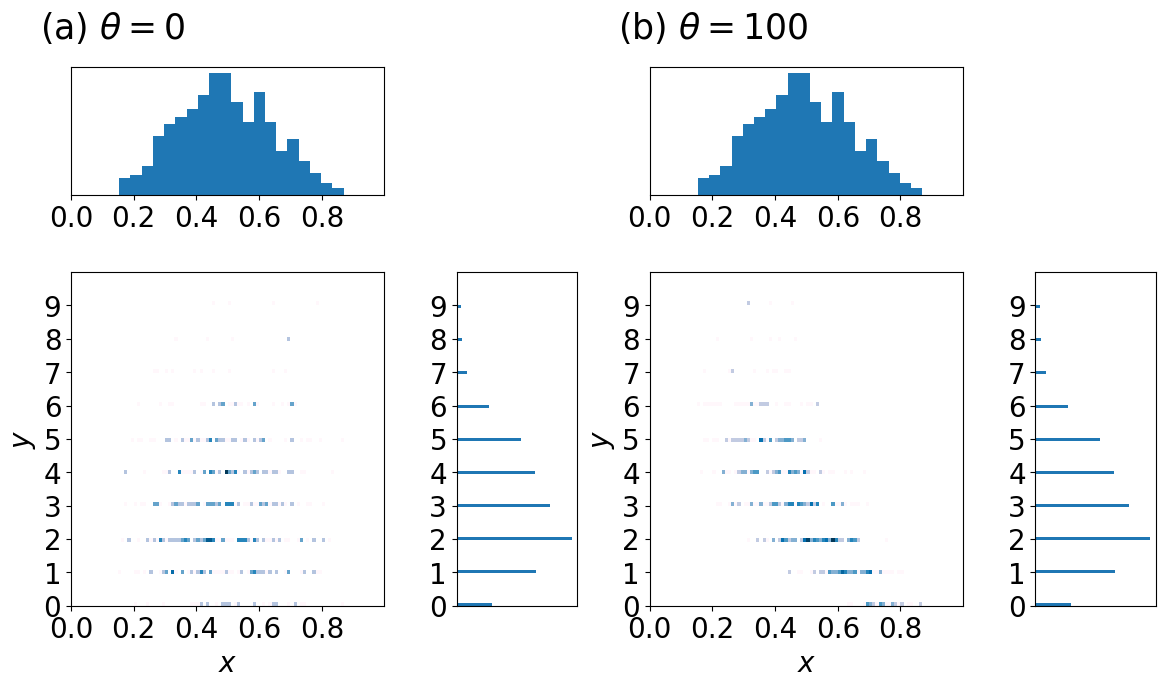

In [136]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14,7))
gs = matplotlib.gridspec.GridSpec(3, 6,wspace=0.6,hspace=0.6)
ax_main_1 = plt.subplot(gs[1:3, :2])
ax_xDist_1 = plt.subplot(gs[0, :2],sharex=ax_main_1)
ax_yDist_1 = plt.subplot(gs[1:3, 2],sharey=ax_main_1)

ax_main_2 = plt.subplot(gs[1:3, 3:5])
ax_xDist_2 = plt.subplot(gs[0, 3:5],sharex=ax_main_2)
ax_yDist_2= plt.subplot(gs[1:3, 5],sharey=ax_main_2)


ax_main_1.hist2d(X,Y,bins=100,range=[[0, 1], [0, 12]],norm=matplotlib.colors.LogNorm(),cmap="PuBu")
ax_main_1.set_xlabel("$x$",fontsize=20)
ax_main_1.set_ylabel("$y$",fontsize=20)
ax_main_1.set_xlim([0,1])
ax_main_1.set_ylim([0,10])
ax_main_1.set_xticks([0.2*i for i in range(5)])
ax_main_1.set_xticklabels([round(0.2*i,2) for i in range(5)],fontsize=20)
ax_main_1.set_yticks([i for i in range(10)])
ax_main_1.set_yticklabels([round(i,2) for i in range(10)],fontsize=20)
ax_main_1.text(-0.1,17,"(a) $\\theta=0$",fontsize=25)

ax_xDist_1.hist(X,bins=20,align='mid')
ax_xDist_1.set(ylabel='')
ax_xDist_1.set_yticks([])
ax_xDist_1.set_xticklabels([round(0.2*i,2) for i in range(5)],fontsize=20)

ax_yDist_1.hist(Y,bins=100,orientation='horizontal',align='mid')
ax_yDist_1.set(xlabel='')
ax_yDist_1.set_xticks([])
ax_yDist_1.set_yticklabels([round(i,2) for i in range(10)],fontsize=20)


ax_main_2.hist2d(np.array(outputlist[-1])[:,0],np.array(outputlist[-1])[:,1],bins=100,range=[[0, 1], [0, 12]],norm=matplotlib.colors.LogNorm(),cmap="PuBu")
ax_main_2.set_xlabel("$x$",fontsize=20)
ax_main_2.set_ylabel("$y$",fontsize=20)
ax_main_2.set_xlim([0,1])
ax_main_2.set_ylim([0,10])
ax_main_2.set_xticks([0.2*i for i in range(5)])
ax_main_2.set_xticklabels([round(0.2*i,2) for i in range(5)],fontsize=20)
ax_main_2.set_yticks([i for i in range(10)])
ax_main_2.set_yticklabels([round(i,2) for i in range(10)],fontsize=20)
ax_main_2.text(-0.1,17,"(b) $\\theta=$"+str(target_th),fontsize=25)

ax_xDist_2.hist(X,bins=20,align='mid')
ax_xDist_2.set(ylabel='')
ax_xDist_2.set_yticks([])
ax_xDist_2.set_xticklabels([round(0.2*i,2) for i in range(5)],fontsize=20)

ax_yDist_2.hist(Y,bins=100,orientation='horizontal',align='mid')
ax_yDist_2.set(xlabel='')
ax_yDist_2.set_xticks([])
ax_yDist_2.set_yticklabels([round(i,2) for i in range(10)],fontsize=20)


###Inference for theta

In [137]:
ex1_PLE=min_info_Besag(X=outputlist[-1],h=h_cd,tol=10**(-5),max_iter=10000,sparseop=False)
#ex1_boot_PLE,ex1_bootm_PLE,ex1_bootcov_PLE=min_info_Besag_bootstrap(X=outputlist[-1],h=h_cd,tol=10**(-5),max_iter=10000,B=100,sparseop=False)

In [138]:
ex1_PLE_asymptoticCov=min_info_Besag_asymptoticCovariance(X=outputlist[-1],h=h_cd,tol=10**(-5),max_iter=10000)

In [144]:
print("Target theta  : "+str(target_th))
print("PLE           : "+str(np.round(ex1_PLE[0],3)))
#print("Bootstrap sd="+str(np.round(np.sqrt(np.diag(ex1_bootcov_PLE)),3)))
print("Asymptotic sd : "+str(np.round(np.sqrt(ex1_PLE_asymptoticCov[0,0]),3)))

Target theta  : 100
PLE           : 95.488
Asymptotic sd : 11.754


In [ ]:
#theta_list,res_list,L_list,AsymptoticCov_list=min_info_CLE(X=outputlist[-1],h=h_cd,L=1000,burnin=10,thin=5,max_L=10**6,max_iter=500,tol=10**(-5),detailop=True)

In [ ]:
#ex1_CLE,ex1_CLE_AsCov = theta_list[-1],AsymptoticCov_list[-1]

In [ ]:
#print("Target theta : "+str(target_th))
#print("CLE with sd : "+str(np.round(ex1_CLE,3))+" with sd="+str(np.round(np.sqrt(np.diag(ex1_CLE_AsCov)),3)))
#print("relative deviation of CLE : "+str(np.round((ex1_CLE-target_th)/target_th,3)))

#Example 2: Penguins data

We use the palmerpenguins dataset from Horst, Hill and Gorman (2020).

- The dataset contains several qualitative and quantitative variables
- We use the variables of (1: continuous) Bill length, (2: continuous) Bill depth, (3: continuous) flipper length, (4: continuous) body mass, (5: discrete) sex
- We test $h(x)=\sum \theta_{ij}x_i x_j$ (second order effect)
and $h(x)=\sum \theta_{ij}x_i x_j + \sum \theta_{ijk}x_i x_j x_k$ (third order effect) after one hot encoding for sex


###References
- K. Gorman, T. Williams, W. Fraser (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081

- A. Horst, A. Hill, K. Gorman (2020). palmerpenguins: Palmer Archipelago (Antarctica) penguin data. R package version 0.1.0. https://allisonhorst.github.io/palmerpenguins/. doi: 10.5281/zenodo.3960218.

In [116]:
!pip install palmerpenguins

from palmerpenguins import load_penguins
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

penguins = load_penguins()
penguins.head()
df = penguins.copy()
df.dropna(how='any')
processed_df=df[df["species"]=="Adelie"].drop(['species','island','year'], axis=1).dropna(how='any')
##Preprocessing
scaling_columns = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"] 
sc = StandardScaler().fit(processed_df[scaling_columns])

# 標準
scaled_df = pd.DataFrame(sc.transform(processed_df[scaling_columns]), columns=scaling_columns, index=processed_df.index)
processed_df.update(scaled_df)
# One hot encoding
processed_df=pd.get_dummies(processed_df,columns=["sex"],drop_first=True)


list_penguins=processed_df.values.tolist()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
def h_penguins_selected(x):
  h_14=x[1-1]*x[4-1]
  h_15=x[1-1]*x[5-1]
  h_24=x[2-1]*x[4-1]
  h_25=x[2-1]*x[5-1]
  h_34=x[3-1]*x[4-1]
  h_45=x[4-1]*x[5-1]
  return np.array([h_14,h_15,h_24,h_25,h_34,h_45])

In [118]:
def h_penguins_selected_includethreefactors(x):
  h_14=x[1-1]*x[4-1]
  h_15=x[1-1]*x[5-1]
  h_24=x[2-1]*x[4-1]
  h_25=x[2-1]*x[5-1]
  h_34=x[3-1]*x[4-1]
  h_45=x[4-1]*x[5-1]
  h_145=x[1-1]*x[4-1]*x[5-1]
  h_245=x[2-1]*x[4-1]*x[5-1]
  return np.array([h_14,h_15,h_24,h_25,h_34,h_45,h_145,h_245])

In [119]:
def h_penguins_all(x):
  h_list = []
  for i in range(5):
    for j in [ k for k in range(5) if (k>i)]:
       h_list.append(x[i]*x[j])
  return np.array(h_list)

In [120]:
ex2_PLE=min_info_Besag(X=list_penguins,h=h_penguins_selected,max_iter=10000,tol=10**(-5))
ex2_boot_PLE,ex2_bootm_PLE,ex2_bootcov_PLE=min_info_Besag_bootstrap(X=list_penguins,h=h_penguins_selected,tol=10**(-5),max_iter=10000,B=100)

In [128]:
ex2_PLE_asymptoticCov=min_info_Besag_asymptoticCovariance(X=list_penguins,h=h_penguins_selected,tol=10**(-5),max_iter=10000)

In [129]:
print("Edge         :1-4  ,1-5  ,2-4  ,2-5  ,3-4  ,4-5  ")
print("PLE          :"+' '.join(['{:.3f}'.format(np.round(ex2_PLE[i],3)) for i in range(6)]))
print("Bootstrap  Sd:"+' '.join(['{:.3f}'.format(np.round(np.sqrt(np.diag(ex2_bootcov_PLE))[i],3)) for i in range(6)]))
print("Asymptotic Sd:"+' '.join(['{:.3f}'.format(np.round(np.sqrt(np.diag(ex2_PLE_asymptoticCov))[i],3)) for i in range(6)]))

Edge         :1-4  ,1-5  ,2-4  ,2-5  ,3-4  ,4-5  
PLE          :0.294 1.524 0.519 1.266 0.613 3.179
Bootstrap  Sd:0.167 0.327 0.188 0.487 0.123 0.655
Asymptotic Sd:0.220 0.520 0.231 0.496 0.164 1.336


In [132]:
ex2_3factor_PLE=min_info_Besag(X=list_penguins,h=h_penguins_selected_includethreefactors,max_iter=10000,tol=10**(-5))
ex2_3factor_boot_PLE,ex2_3factor_bootm_PLE,ex2_3factor_bootcov_PLE=min_info_Besag_bootstrap(X=list_penguins,h=h_penguins_selected_includethreefactors,tol=10**(-5),max_iter=10000,B=100)

In [133]:
ex2_3factor_PLE_asymptoticCov=min_info_Besag_asymptoticCovariance(X=list_penguins,h=h_penguins_selected_includethreefactors,tol=10**(-5),max_iter=10000)

In [134]:
print("Edge         :1-4     1-5     2-4     2-5     3-4     4-5     1-4-5   2-4-5")
print("PLE          :"+'   '.join(['{:.3f}'.format(np.round(ex2_3factor_PLE[i],3)) for i in range(8)]))
print("Bootstrap  Sd:"+'   '.join(['{:.3f}'.format(np.round(np.sqrt(np.diag(ex2_3factor_bootcov_PLE))[i],3)) for i in range(8)]))
print("Asymptotic Sd:"+'   '.join(['{:.3f}'.format(np.round(np.sqrt(np.diag(ex2_3factor_PLE_asymptoticCov))[i],3)) for i in range(8)]))

Edge         :1-4     1-5     2-4     2-5     3-4     4-5     1-4-5   2-4-5
PLE          :0.360   1.495   1.084   1.195   0.622   3.224   -0.115   -0.855
Bootstrap  Sd:0.275   0.352   0.358   0.452   0.109   0.610   0.319   0.419
Asymptotic Sd:0.392   0.529   0.432   0.510   0.164   1.345   0.478   0.498


In [ ]:
#theta_list,res_list,L_list,AsymptoticCov_list=min_info_CLE(X=list_penguins,h=h_penguins_selected,L=1000,burnin=10,thin=5,max_L=10**6,max_iter=500,tol=10**(-3),detailop=False)

In [ ]:
#ex2_CLE,ex2_CLE_AsCov = theta_list[-1],AsymptoticCov_list[-1]

In [ ]:
#print("CLE with sd : "+str(np.round(ex2_CLE,3))+" with sd="+str(np.round(np.sqrt(np.diag(ex2_CLE_AsCov)),3)))

#Example 3: Earthquake catalog data

- We analyze the dependence between mechanism solution and depth in the earthquake catalog
- We use the 158 earthquake data that occurred in Japan during the period from January 1st, 2021 to December 8th, 2021 
- The data we use are provided by the Japan Meteorological Agency and contain
the information about (0) time (1) latitude (2) longitude (3) depth (4) Magnitude (5) JMA Magnitude (6) strike 1 (7) dip 1 (8) slip 1 (9) strike 2 (10) dip 2 (11) slip 2 of the events
- We use the columns of (3) depth ,(6)-(11) mechanism solution
- The mechanism solution of an earthquake event is given in the form of two orthogonal axes in the 3D space (Arnold and Jupp, 2013): $\{v_P,v_T\in \mathbb{R}^{3}: (v_P)^{\top}v_T=0, \|v_P\|=1, \|v_T\|=1\}$
- To analyze the dependence between mechanism solution and depth, we consider the minimum information dependence model with the form
$\exp(\mathrm{tr}(A(z v_{P}v_{P}^{\top})) + \mathrm{tr}(B(z v_{T}v_{T}^{\top})) +\text{terms related to marginals})$, where $z$ is the depth.

###References
- JAPAN METEOROLOGICAL AGENCY (2022). The seismological bulletin of Japan. https://www.data.jma.go.jp/svd/eqev/data/bulletin/index_e.html.
- R. Arnold and P. Jupp (2013). Statistics of orthogonal axial frames. Biometrika 100 571–586.

In [ ]:
Mechsol_df=pd.read_csv('./gdrive/My Drive/min-info/code/Mechsol_format.csv')

#Preprocessing of lat / lon/ depth

Mechsol_df["latitude"]=np.array([np.round(float(Mechsol_df["latitude"][i].split(":")[0])+float(Mechsol_df["latitude"][i].split(":")[1])/60,3) for i in range(Mechsol_df.shape[0])])
Mechsol_df["longitude"]=np.array([np.round(float(Mechsol_df["longitude"][i].split(":")[0])+float(Mechsol_df["longitude"][i].split(":")[1])/60,3) for i in range(Mechsol_df.shape[0])])
Mechsol_df["depth"]=np.array([float(Mechsol_df["depth"][i][:-2]) for i in range(Mechsol_df.shape[0]) ])

#Standardization of depth

from sklearn.preprocessing import StandardScaler
scaling_columns = ["depth"] 
sc = StandardScaler().fit(Mechsol_df[scaling_columns])
scaled_df = pd.DataFrame(sc.transform(Mechsol_df[scaling_columns]), columns=scaling_columns, index=Mechsol_df.index)
Mechsol_df.update(scaled_df)

In [ ]:
#Converting strike/dip/slip into a vector
#Reference: https://www.data.jma.go.jp/svd/eqev/data/mech/kaisetu/mechkaisetu2.html

def angle2vec(strike,dip,slip):
  phi   = strike * (2*np.pi) / 360
  delta = dip    * (2*np.pi) / 360
  lam   = slip   * (2*np.pi) / 360
  ####
  v1    = np.cos(lam)*np.cos(phi) + np.sin(lam)*np.cos(delta)*np.sin(phi)
  v2    = np.cos(lam)*np.sin(phi) - np.sin(lam)*np.cos(delta)*np.cos(phi)
  v3    = -np.sin(lam)*np.sin(delta)
  v     = np.array([v1,v2,v3])
  return v.T


#Orthogonalization
#vec 1 and vec 2 are nearly orthogonal but not exactly orthogonal; so we orthogonalize these in the following step.

vec1       =angle2vec(Mechsol_df["strike1"], Mechsol_df["dip1"], Mechsol_df["slip1"])
vec2       =angle2vec(Mechsol_df["strike2"], Mechsol_df["dip2"], Mechsol_df["slip2"])
vec2_ortho = vec2-(np.diag((np.diag(vec1.dot(vec2.T))/np.diag(vec1.dot(vec1.T)))).dot(vec1))
vec2       = np.diag(1/np.sqrt(np.diag(vec2_ortho.dot(vec2_ortho.T)))).dot(vec2_ortho)

#Calculate N-axis, the cross product of vec1 and vec2
vec3 = np.cross(vec1 , vec2, axisc=1)
vec3 = np.diag(1/np.sqrt(np.diag(vec3.dot(vec3.T)))).dot(vec3)


#Store P-axis/T-axis/N-axis
Mechsol_df["P-axis P1"] = (vec1-vec2)[:,0]/np.sqrt(2)
Mechsol_df["P-axis P2"] = (vec1-vec2)[:,1]/np.sqrt(2)
Mechsol_df["P-axis P3"] = (vec1-vec2)[:,2]/np.sqrt(2)

Mechsol_df["T-axis T1"] = (vec1+vec2)[:,0]/np.sqrt(2)
Mechsol_df["T-axis T2"] = (vec1+vec2)[:,1]/np.sqrt(2)
Mechsol_df["T-axis T3"] = (vec1+vec2)[:,2]/np.sqrt(2)

Mechsol_df["N-axis N1"] = vec3[:,0]
Mechsol_df["N-axis N2"] = vec3[:,1]
Mechsol_df["N-axis N3"] = vec3[:,2]

In [ ]:
selected_columns=["depth","P-axis P1","P-axis P2","P-axis P3","T-axis T1","T-axis T2","T-axis T3","N-axis N1","N-axis N2","N-axis N3"]
list_mechsol= Mechsol_df[selected_columns].values.tolist()

In [ ]:
def h_mechsol(x):
  #x[0]: depth
  #x[1],x[2],x[3]: P-axis
  #x[4],x[5],x[6]: T-axis
  #x[7],x[8],x[9]: N-axis
  hP_11 = x[0] * x[1] * x[1]
  hP_12 = x[0] * x[1] * x[2]
  hP_13 = x[0] * x[1] * x[3]
  hP_22 = x[0] * x[2] * x[2]
  hP_23 = x[0] * x[2] * x[3]
  hT_11 = x[0] * x[4] * x[4]
  hT_12 = x[0] * x[4] * x[5]
  hT_13 = x[0] * x[4] * x[6]
  hT_22 = x[0] * x[5] * x[5]
  hT_23 = x[0] * x[5] * x[6]
  return np.array([hP_11,hP_12,hP_13,hP_22,hP_23, hT_11,hT_12,hT_13,hT_22,hT_23])

In [ ]:
ex3_PLE=min_info_Besag(X=list_mechsol,h=h_mechsol,max_iter=10000,tol=10**(-5))
ex3_boot_PLE,ex3_bootm_PLE,ex3_bootcov_PLE=min_info_Besag_bootstrap(X=list_mechsol,h=h_mechsol,tol=10**(-5),max_iter=10000,B=100)

In [ ]:

# interpretable representation
A_PLE = np.matrix(np.zeros(9)).reshape(3,3)  # compressional part
A_PLE[0,0] = ex3_PLE[0]
A_PLE[0,1] = ex3_PLE[1]
A_PLE[0,2] = ex3_PLE[2]
A_PLE[1,1] = ex3_PLE[3]
A_PLE[1,2] = ex3_PLE[4]
A_PLE = (A_PLE + A_PLE.T)/2
A_PLE_adjust  = A_PLE - linalg.eigvals(A_PLE)[1].real * np.diag([1,1,1])


##Uncertainty calculus based on bootstrap
A_U = []
v1_A_U  = []
v3_A_U  = []

for b in range(len(ex3_boot_PLE)):

  mid_matrix_A = np.matrix(np.zeros(9)).reshape(3,3)
  mid_matrix_A[0,0] = ex3_boot_PLE[b][0]
  mid_matrix_A[0,1] = ex3_boot_PLE[b][1]
  mid_matrix_A[0,2] = ex3_boot_PLE[b][2]
  mid_matrix_A[1,1] = ex3_boot_PLE[b][3]
  mid_matrix_A[1,2] = ex3_boot_PLE[b][4]
  mid_matrix_A = (mid_matrix_A + mid_matrix_A.T)/2
  mid_matrix_A_adjust  = mid_matrix_A - linalg.eigvals(mid_matrix_A)[1].real * np.diag([1,1,1])

  A_U.append(mid_matrix_A_adjust)
  if  (linalg.eigvals(mid_matrix_A_adjust)[0].real > linalg.eigvals(mid_matrix_A_adjust)[2].real) :
    v1_A_U.append( linalg.eig(mid_matrix_A_adjust )[1][:,0] )
    v3_A_U.append( linalg.eig(mid_matrix_A_adjust )[1][:,2] )
  else:
    v1_A_U.append( linalg.eig(mid_matrix_A_adjust )[1][:,2] )
    v3_A_U.append( linalg.eig(mid_matrix_A_adjust )[1][:,0] ) 

if linalg.eigvals(A_PLE_adjust)[0].real > linalg.eigvals(A_PLE_adjust)[2].real:
  v1 = linalg.eig(A_PLE_adjust)[1][:,0]
  v3 = linalg.eig(A_PLE_adjust)[1][:,2]
else:
  v1 = linalg.eig(A_PLE_adjust)[1][:,2]
  v3 = linalg.eig(A_PLE_adjust)[1][:,0]  

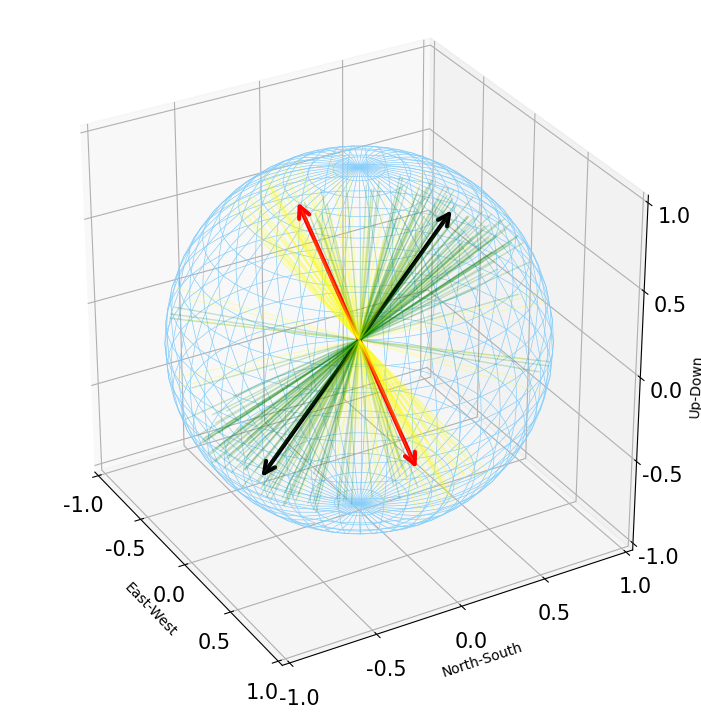

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, start=[0,0,0], end=[1,1,1], *args, **kwargs):
        if "arrowstyle" not in kwargs:
            kwargs["arrowstyle"] = "-"
        if "mutation_scale" not in kwargs:
            kwargs["mutation_scale"] = 20
        if "color" not in kwargs:
            kwargs["color"] = "k"
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        xs = [start[0], end[0]]
        ys = [start[1], end[1]]
        zs = [start[2], end[2]]
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)


fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))

# sphere
u,v=np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
x=np.cos(u)*np.sin(v) 
y=np.sin(u)*np.sin(v) 
z=np.cos(v)
ax.plot_wireframe(x, y, z, color='lightskyblue', linewidth=0.5)
ax.set_xlim([-1,1])
ax.set_xticks([-1+0.5*i for i in range(5)])
ax.set_xticklabels([round(-1+0.5*i,2) for i in range(5)],fontsize=15)
ax.set_ylim([-1,1])
ax.set_yticks([-1+0.5*i for i in range(5)])
ax.set_yticklabels([round(-1+0.5*i,2) for i in range(5)],fontsize=15)
ax.set_zlim([-1,1])
ax.set_zticks([-1+0.5*i for i in range(5)])
ax.set_zticklabels([round(-1+0.5*i,2) for i in range(5)],fontsize=15)
ax.set_xlabel("East-West",fontsize=10)
ax.set_ylabel("North-South",fontsize=10)
ax.set_zlabel("Up-Down",fontsize=10)
ax.view_init(30, -30)
for i in range(100):
  start1 = [np.array(v1_A_U)[i,0],np.array(v1_A_U)[i,1],np.array(v1_A_U)[i,2]]
  start3 = [np.array(v3_A_U)[i,0],np.array(v3_A_U)[i,1],np.array(v3_A_U)[i,2]]
  ax.add_artist(Arrow3D(start=list(-np.array(start1)), end=list(start1),color="yellow",alpha=0.2))
  ax.add_artist(Arrow3D(start=list(-np.array(start3)), end=list(start3),color="green",alpha=0.2))

ax.add_artist(Arrow3D(start=list(-v1), end=list(v1),color="red",linewidth=3,arrowstyle="<->"))
ax.add_artist(Arrow3D(start=list(-v3), end=list(v3),color="black",linewidth=3,arrowstyle="<->"))
plt.subplots_adjust(left=0.1, right=1.2, bottom=0.1, top=0.95)
plt.show()